**Практическое задание:**:
1. Взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
2. сделать обзорный анализ выбранного датасета
3. сделать feature engineering
4. обучить любой классификатор (какой вам нравится)
5. разобраться с SHAP и построить важности признаков для:
 - всего **тестового** набора данных (summary_plot - дать интерпретацию)
 - для топ 10% (сортировка по убыванию вероятности - таргета)
6. для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат
7. (опциональное задание) для примера из вебинара (model A, model B) рассчитать shap-значения для точки {Fever=1, Cough=0}

**Ссылки**:
1. Пример с Permutation Importance - https://www.kaggle.com/dansbecker/permutation-importance
2. Github проекта SHAP - https://github.com/slundberg/shap
3. https://arxiv.org/pdf/1809.04559.pdf
4. https://medium.com/civis-analytics/demystifying-black-box-models-with-shap-value-analysis-3e20b536fc80
5. https://en.wikipedia.org/wiki/Shapley_value

**Feature selection**:
1. RFE - recursive feature elimination (есть в sklearn)
2. Boruta - shadow features
3. Target permutation

**В этом ДЗ я продолжу работать с датасетом, который использовал в предыдущем ДЗ №6**: https://github.com/alex-kalinichenko/gb/blob/master/ml_in_business/hw_6.ipynb

**Distinguish between the presence and absence of cardiac arrhythmia and classify it in one of the 16 groups.**

Полное описание данных здесь: - https://archive.ics.uci.edu/ml/datasets/Arrhythmia

Выборочные описания:

1. Age: Age in years , linear
2. Sex: Sex (0 = male; 1 = female) , nominal
3. Height: Height in centimeters , linear
4. Weight: Weight in kilograms , linear
5. QRS duration: Average of QRS duration in msec., linear
6. P-R interval: Average duration between onset of P and Q waves in msec., linear
7. Q-T interval: Average duration between onset of Q and offset of T waves in msec., linear
8. T interval: Average duration of T wave in msec., linear
9. P interval: Average duration of P wave in msec., linear
Vector angles in degrees on front plane of:, linear
10. QRS
11. T
12. P
13. QRST
14. J

15. Heart rate: Number of heart beats per minute ,linear

16-20: channels DI:

21 Number of intrinsic deflections, linear

22-27: Existence of waves

28-159: Сhannels DII:

160-167: channels DI:

168 QRSA , Sum of areas of all segments divided by 10, ( Area= width * height / 2 ), linear
169 QRSTA = QRSA + 0.5 * width of T wave * 0.1 * height of T wave. (If T is diphasic then the bigger segment is considered), linear

170-279: Channels DII:

**Т.е. названия колонок - это цифры от 1-280, а пордковые номера от 0 до 270, может быть некоторая путаница в именах признаков!!!**

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import (mean_absolute_error, r2_score, recall_score, precision_score, 
                            roc_auc_score, accuracy_score, f1_score)
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import xgboost as xgb

import shap
# load JS visualization code to notebook
shap.initjs()

In [2]:
df = pd.read_csv("../../data/ml_in_business/arrhythmia/arrhythmia.data", header=None)
df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,270,271,272,273,274,275,276,277,278,279
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4,8
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,6
2,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,10


In [3]:
pd.set_option('display.max_columns', 300)
df.describe().round(1)

,0,1,2,3,4,5,6,7,8,9,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279
count,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0,452.0
mean,46.5,0.6,166.2,68.2,88.9,155.2,367.2,169.9,90.0,33.7,5.6,51.6,20.9,0.1,0.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,5.6,54.3,20.6,0.4,0.2,31.6,0.0,0.0,0.0,0.0,0.0,0.0,16.0,42.0,20.3,2.3,0.3,30.5,0.0,0.0,0.0,0.0,0.0,0.0,45.4,19.3,7.8,2.8,0.1,31.2,0.0,0.0,0.0,0.0,0.0,0.0,10.3,43.6,19.8,0.8,0.0,27.3,0.0,0.0,0.0,0.0,0.0,0.0,7.5,50.4,19.8,0.8,0.2,29.9,0.0,0.0,0.0,0.0,0.0,0.0,12.6,23.8,42.1,4.0,0.1,18.7,0.0,0.0,0.0,0.0,0.0,0.0,6.3,33.6,43.6,2.0,0.2,22.6,0.0,0.0,0.0,0.0,0.0,0.0,3.8,42.5,41.7,0.5,0.1,27.7,0.0,0.0,0.0,0.0,0.0,0.0,3.2,46.1,42.4,0.5,0.1,31.0,0.0,0.0,0.0,0.0,0.0,0.0,4.9,46.9,39.9,0.3,0.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,6.7,50.2,28.3,0.2,0.0,32.2,0.0,0.0,0.0,0.0,0.0,0.0,-0.2,-0.2,6.0,-1.0,0.0,0.0,0.6,1.0,13.8,20.8,-0.1,-0.2,7.2,-1.3,0.0,-0.0,1.0,1.4,17.0,27.0,0.1,-1.0,3.5,-1.7,0.2,-0.0,0.4,0.4,2.7,5.6,0.1,-5.2,0.9,-1.1,0.1,-0.0,-0.8,-1.1,-15.6,-23.5,-0.2,-0.5,3.4,-1.2,0.0,0.0,0.1,0.3,5.5,7.3,-0.0,-0.4,4.9,-1.3,0.1,-0.0,0.7,0.9,9.8,16.0,0.7,-1.4,1.6,-6.6,0.3,-0.0,-0.3,0.2,-18.7,-15.9,1.0,-0.9,4.0,-9.0,0.2,-0.0,0.0,2.6,-18.0,10.2,0.8,-0.7,8.0,-10.2,0.0,-0.0,0.2,3.9,-8.3,32.4,0.0,-0.3,11.8,-7.0,0.0,-0.0,0.5,2.5,10.1,33.3,-0.3,-0.3,11.4,-3.6,0.0,0.0,0.5,1.7,17.8,32.9,-0.3,-0.3,9.0,-1.5,0.0,0.0,0.5,1.2,19.3,29.5,3.9
std,16.5,0.5,37.2,16.6,15.4,44.8,33.4,35.6,25.8,45.4,10.7,18.2,20.5,1.6,0.0,10.0,0.0,0.1,0.1,0.1,0.1,0.1,11.2,17.2,21.1,3.1

In [4]:
df.iloc[:,279].nunique(), np.sort(df.iloc[:,279].unique())

(13, array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 14, 15, 16], dtype=int64))

У признака 16 классов классификации (номер признака, название, количество):
- 01 - Normal				          245
- 02 - Ischemic changes (Coronary Artery Disease)   44
- 03 - Old Anterior Myocardial Infarction           15
- 04 - Old Inferior Myocardial Infarction           15
- 05 - Sinus tachycardy			           13
- 06 - Sinus bradycardy			           25
- 07 - Ventricular Premature Contraction (PVC)       3
- 08 - Supraventricular Premature Contraction	    2
- 09 - Left bundle branch block 		            9	
- 10 - Right bundle branch block		           50
- 11 - 1. degree AtrioVentricular block	            0	
- 12 - 2. degree AV block		            0
- 13 - 3. degree AV block		            0
- 14 - Left ventricule hypertrophy 	            4
- 15 - Atrial Fibrillation or Flutter	            5
- 16 - Others				           22

**Будем распознавать класс 2 с ишемическими изменениями. Остальное приравняем к норме.**

In [5]:
data = df.copy()
data[279].replace([1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], 0, inplace=True)
data[279].replace(2, 1, inplace=True)
data[279]

0      0
1      0
2      0
3      0
4      0
      ..
447    0
448    0
449    1
450    0
451    0
Name: 279, Length: 452, dtype: int64

У нас есть 280 признаков и 1 целевая переменная (бинарная) - нужно определить есть ишемические изменения или нет.

In [6]:
print(data.shape)

(452, 280)


Всего 452 объекта

Посмотрим на соотношение классов

In [7]:
data.iloc[:, -1].value_counts()

0    408
1     44
Name: 279, dtype: int64

In [8]:
def get_num_features(df):
    """
    функция возвращает список числовых признаков
    :param df
    :return: list
    """
    numerical_features = df.select_dtypes(include=[np.number])
    # print(f"count of numeric_features_train {numerical_features.shape[1]}")
    return numerical_features.columns


def get_cat_features(df):
    """
    функция возвращает список признаков с типом "объект"
    :param df:
    :return: list
    """
    categorical_features = df.select_dtypes(include=[np.object])
    return categorical_features.columns

Числовые принаки

In [9]:
get_num_features(data)

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            270, 271, 272, 273, 274, 275, 276, 277, 278, 279],
           dtype='int64', length=275)

Категориальные признаки

In [10]:
get_cat_features(data)

Int64Index([10, 11, 12, 13, 14], dtype='int64')

# Анализ данных

Посмотрим на типы данных по столбцам

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452 entries, 0 to 451
Columns: 280 entries, 0 to 279
dtypes: float64(120), int64(155), object(5)
memory usage: 988.9+ KB


Проверим как распределена целевая переменная.

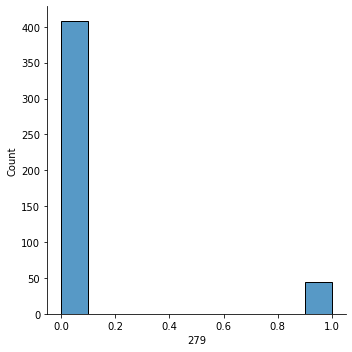

In [12]:
sns.displot(data, x=data[279]);

__Вывод:__ целевая имеет **дисбаланс классов**. Это нужно учитывать при построении модели.

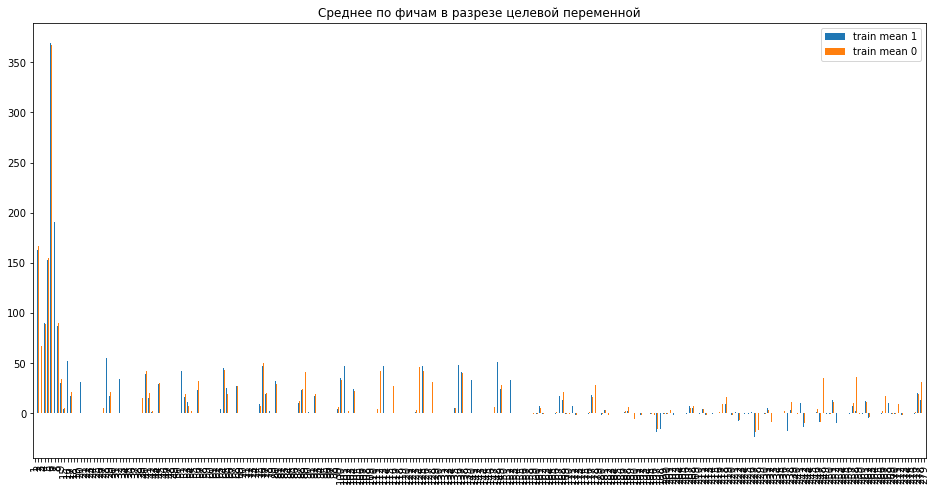

In [13]:
df = pd.DataFrame({
    # среднее по всем фичам трейна за исключением таргета
    'train mean 1': data.loc[data[279]==1, :].describe().iloc[1,1:],
    # среднее по всем фичам теста (здесь таргета нет)
    'train mean 0': data.loc[data[279]==0, :].describe().iloc[1,1:]
})

df.plot.bar(figsize=(16,8))
plt.title('Среднее по фичам в разрезе целевой переменной');

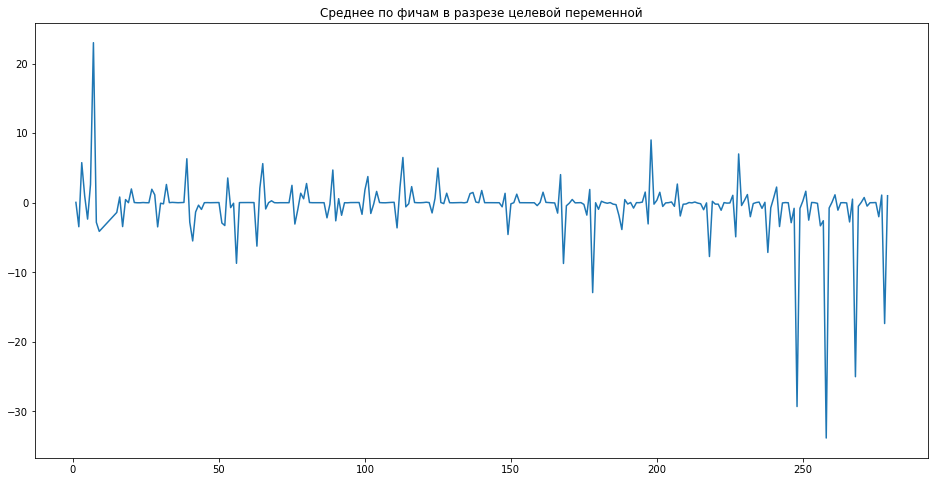

In [14]:
df =  data.loc[data[279]==1, :].describe().iloc[1,1:] - data.loc[data[279]==0, :].describe().iloc[1,1:]

df.plot(figsize=(16,8))
plt.title('Среднее по фичам в разрезе целевой переменной');

# Заполнение пропусков

Посмотрим на категориальные признаки повнимательнее. Видим, что все они числовые, но представлены в строковм выражении из-за того, что пропуски заполнены "?".

In [15]:
data[10].unique()

array(['13', '37', '34', '11', '66', '49', '7', '69', '71', '42', '51',
       '20', '45', '75', '-24', '28', '39', '78', '56', '10', '17', '112',
       '52', '48', '153', '172', '16', '32', '46', '23', '35', '3', '-8',
       '-5', '4', '60', '8', '-18', '76', '64', '9', '79', '33', '14',
       '30', '53', '25', '62', '?', '43', '31', '19', '50', '68', '-164',
       '-56', '15', '-2', '87', '-136', '175', '-124', '142', '-13', '-9',
       '58', '47', '-165', '73', '21', '38', '70', '-92', '143', '22',
       '72', '57', '41', '65', '36', '63', '55', '44', '77', '24', '81',
       '12', '29', '18', '40', '54', '-1', '104', '-167', '-15', '67',
       '108', '-75', '160', '114', '-22', '120', '-115', '147', '-82',
       '-63', '-172', '102', '179', '86', '-52', '-49', '174', '-27',
       '95', '-123', '61', '137', '164', '5', '-177', '-103', '-106',
       '-42', '117', '127', '-160', '122', '59', '-16', '26', '100', '0',
       '-21', '-121', '-174', '-51', '105', '-116', '-4', '

Заменяем знаки вопроса на мединные значения по признаку

In [16]:
for col in [10, 11, 12, 13, 14]:
    # извлекаем индексы по условию (тех элементов, которые имеют значение "?")
    indices = np.where(data[col] != '?')
    # получаем спиcок элементов по индексам [0], приводим к строке, к целому и находим медиану
    col_med = np.median(np.take(data[col], indices[0]).astype(str).astype(int))
    # заменяем некорректное значение медианой
    data[col] = data[col].replace('?', col_med)

Проверям что "?" заменились на медиану.

In [17]:
data[10].unique()

array(['13', '37', '34', '11', '66', '49', '7', '69', '71', '42', '51',
       '20', '45', '75', '-24', '28', '39', '78', '56', '10', '17', '112',
       '52', '48', '153', '172', '16', '32', '46', '23', '35', '3', '-8',
       '-5', '4', '60', '8', '-18', '76', '64', '9', '79', '33', '14',
       '30', '53', '25', '62', 41.0, '43', '31', '19', '50', '68', '-164',
       '-56', '15', '-2', '87', '-136', '175', '-124', '142', '-13', '-9',
       '58', '47', '-165', '73', '21', '38', '70', '-92', '143', '22',
       '72', '57', '41', '65', '36', '63', '55', '44', '77', '24', '81',
       '12', '29', '18', '40', '54', '-1', '104', '-167', '-15', '67',
       '108', '-75', '160', '114', '-22', '120', '-115', '147', '-82',
       '-63', '-172', '102', '179', '86', '-52', '-49', '174', '-27',
       '95', '-123', '61', '137', '164', '5', '-177', '-103', '-106',
       '-42', '117', '127', '-160', '122', '59', '-16', '26', '100', '0',
       '-21', '-121', '-174', '-51', '105', '-116', '-4', 

Коневертируем признаки в целые числа

In [18]:
for col in [10, 11, 12, 13, 14]:
    data[col] = data[col].astype(int)

In [19]:
%%time
parameters = {"max_depth": 6, "n_estimators": 25, "random_state": 27, "n_jobs": 8}

forest = RandomForestRegressor(**parameters)
forest.fit(data.drop([279], axis=1), data[279])

Wall time: 86 ms


RandomForestRegressor(max_depth=6, n_estimators=25, n_jobs=8, random_state=27)

Text(0.5, 1.0, 'Топ 10 важных признаков')

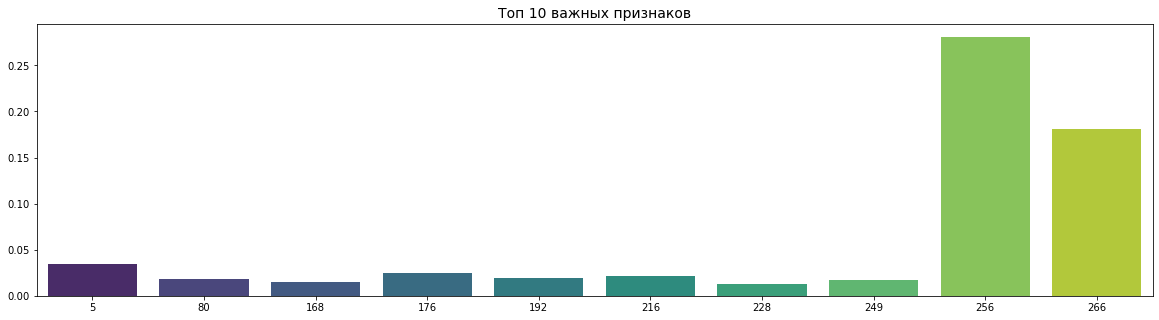

In [20]:
n_top = 10
importances = forest.feature_importances_
idx = np.argsort(importances)[::-1][0:n_top]
feature_names = data.drop([279], axis=1).columns

plt.figure(figsize=(20, 5))
sns.barplot(x=feature_names[idx], y=importances[idx], palette="viridis")
plt.title("Топ 10 важных признаков", size=14)

Самые важные ризнаки № 256 и 266.

# Feature engineering

Создадим признак Body Mass Index = weight / (height (in meter) ** 2)

In [21]:
data['bmi'] = round(data[3] / ((data[2] / 100) ** 2), 1)
data.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,bmi
0,75,0,190,80,91,193,371,174,121,-16,13,64,-2,-50,63,0,52,44,0,0,32,0,0,0,0,0,0,0,44,20,36,0,28,0,0,0,0,0,0,52,40,0,0,0,60,0,0,0,0,0,0,52,0,0,0,0,0,0,0,0,0,0,0,0,56,36,0,0,32,0,0,0,0,0,0,48,32,0,0,0,56,0,0,0,0,0,0,80,0,0,0,0,0,0,0,0,0,0,0,0,40,52,0,0,28,0,0,0,0,0,0,0,48,48,0,0,32,0,0,0,0,0,0,0,52,52,0,0,36,0,0,0,0,0,0,0,52,48,0,0,32,0,0,0,0,0,0,0,56,44,0,0,32,0,0,0,0,0,0,-0.2,0.0,6.1,-1.0,0.0,0.0,0.6,2.1,13.6,30.8,0.0,0.0,1.7,-1.0,0.6,0.0,1.3,1.5,3.7,14.5,0.1,-5.2,1.4,0.0,0.0,0.0,0.8,-0.6,-10.7,-15.6,0.4,-3.9,0.0,0.0,0.0,0.0,-0.8,-1.7,-10.1,-22.0,0.0,0.0,5.7,-1.0,0.0,0.0,-0.1,1.2,14.1,22.5,0.0,-2.5,0.8,0.0,0.0,0.0,1.0,0.4,-4.8,-2.7,0.1,-6.0,0.0,0.0,0.0,0.0,-0.8,-0.6,-24.0,-29.7,0.0,0.0,2.0,-6.4,0.0,0.0,0.2,2.9,-12.6,15.2,-0.1,0.0,8.4,-10.0,0.0,0.0,0.6,5.9,-3.9,52.7,-0.3,0.0,15.2,-8.4,0.0,0.0,0.9,5.1,17.7,70.7,-0.4,0.0,13.5,-4.0,0.0,0.0,0.9,3.9,25.5,62.9,-0.3,0.0,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4,0,22.2
1,56,1,165,64,81,174,401,149,39,25,37,-17,31,-50,53,0,48,0,0,0,24,0,0,0,0,0,0,0,64,0,0,0,24,0,0,0,0,0,0,32,24,0,0,0,40,0,0,0,0,0,0,48,0,0,0,0,0,0,0,0,0,0,0,0,44,20,0,0,24,0,0,0,0,0,0,0,60,0,0,0,20,0,0,0,0,0,0,0,24,52,0,0,16,0,0,0,0,0,0,0,32,52,0,0,20,0,0,0,0,0,0,0,44,48,0,0,32,0,0,0,0,0,0,0,48,44,0,0,32,0,0,0,0,0,0,0,48,40,0,0,28,0,0,0,0,0,0,0,48,0,0,0,28,0,0,0,0,0,0,-0.6,0.0,7.2,0.0,0.0,0.0,0.4,1.5,17.2,26.5,0.0,0.0,5.5,0.0,0.0,0.0,0.1,1.7,17.6,29.5,0.3,-1.6,0.9,0.0,0.0,0.0,-0.3,0.4,-1.5,1.3,0.1,-6.4,0.0,0.0,0.0,0.0,-0.3,-1.6,-15.3,-25.5,-0.3,0.0,4.2,-0.9,0.0,0.0,0.4,0.7,8.3,12.3,0.2,0.0,2.2,0.0,0.0,0.0,-0.2,0.8,6.6,11.7,0.4,0.0,1.0,-8.8,0.0,0.0,0.5,-0.6,-21.6,-26.8,0.4,0.0,2.6,-7.9,0.0,0.0,0.8,2.0,-16.4,1.2,0.0,0.0,5.8,-7.7,0.0,0.0,0.9,3.8,-5.7,27.7,-0.2,0.0,9.5,-5.0,0.0,0.0,0.5,2.6,11.8,34.6,-0.4,0.0,11.0,-2.4,0.0,0.0,0.4,2.6,21.6,43.4,-0.5,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,0,23.5
2,54,0,172,95,138,163,386,185,102,96,34,70,66,23,75,0,40,80,0,0,24,0,0,0,0,0,0,20,56,52,0,0,40,0,0,0,0,0,0,28,116,0,0,0,52,0,0,0,0,0,0,52,64,0,0,0,88,0,0,0,0,0,0,0,36,92,0,0,24,0,0,0,0,0,0,0,128,0,0,0,24,0,1,0,0,0,0,0,24,36,76,0,100,0,0,0,0,0,0,0,40,28,60,0,96,0,0,0,0,0,0,0,48,20,56,24,32,0,0,0,0,0,0,0,44,88,0,0,28,0,0,0,0,0,0,0,44,76,0,0,28,0,0,0,0,0,0,0,44,72,0,0,24,0,0,0,0,0,0,1.0,0.0,4.5,-2.8,0.0,0.0,0.3,2.5,-2.2,19.8,0.8,-0.4,6.4,-1.3,0.0,0.0,0.7,2.7,14.2,37.9,-0.2,-0.6,4.4,0.0,0.0,0.0,0.5,0.2,24.7,26.2,-1.0,-5.3,1.8,0.0,0.0,0.0,-0.5,-2.5,-8.0,-28.5,0.5,0.0,1.7,-2.7,0.0,0.0,-0.2,1.0,-9.4,-1.2,0.4,0.0,4.9,0.0,0.0,0.0,0.6,1.4,31.3,42.7,-0.8,0.0,0.7,-3.8,6.5,0.0,0.3,-3.3,18.7,-13.6,-0.9,0.0,2.2,-4.1,7.4,0.0,0.5,-2.4,20.9,-2.6,0.0,0.0,5.8,-4.1,4.0,-0.5,0.4,0.3,20.4,23.3,0.7,0.0,10.0,-5.7,0.0,0.0,0.5,2.2,-3.0,20.7,1.3,0.0,11.1,-3.4,0.0,0.0,0.4,3.4,11.5,48.2,0.9,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,0,32.1
3,55,0,175,94,100,202,380,179,143,28,11,-5,20,-50,71,0,72,20,0,0,48,0,0,0,0,0,0,0,64,36,0,0,36,0,0,0,0,0,0,20,52,48,0,0,56,0,0,0,0,0,0,64,32,0,0,0,72,0,0,0,0,0,0,0,60,12,0,0,44,0,0,0,0,0,0,0,60,44,0,0,32,0,0,0,0,0,0,56,0,0,0,0,0,0,0,0,0,0,0,0,40,4

In [22]:
data[0].nunique()

77

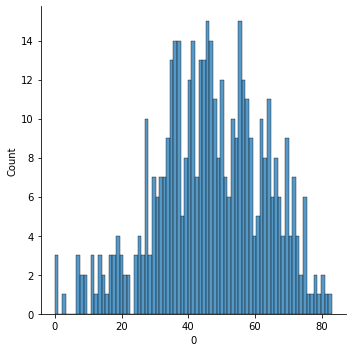

In [23]:
fig_dims = (10, 4)
sns.displot(data, x=data[0], bins=data[0].nunique());

<Figure size 1152x360 with 0 Axes>

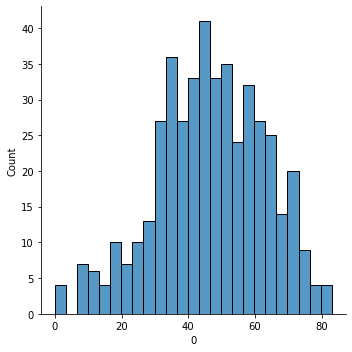

In [24]:
plt.figure(figsize=(16, 5))
sns.displot(data, x=data[0], bins=25 );

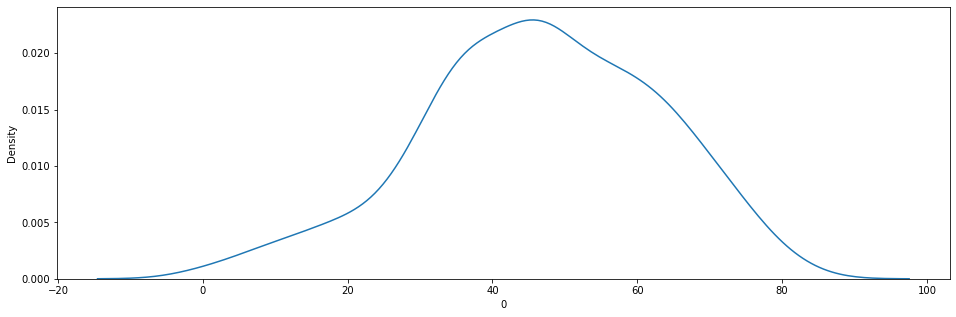

In [25]:
plt.figure(figsize=(16, 5))
sns.kdeplot(data=data[0]);

Возраст в квадрате

In [26]:
data['Age Sqrt'] = np.sqrt(data[0])
data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,bmi,Age Sqrt
0,75,0,190,80,91,193,371,174,121,-16,13,64,-2,-50,63,0,52,44,0,0,32,0,0,0,0,0,0,0,44,20,36,0,28,0,0,0,0,0,0,52,40,0,0,0,60,0,0,0,0,0,0,52,0,0,0,0,0,0,0,0,0,0,0,0,56,36,0,0,32,0,0,0,0,0,0,48,32,0,0,0,56,0,0,0,0,0,0,80,0,0,0,0,0,0,0,0,0,0,0,0,40,52,0,0,28,0,0,0,0,0,0,0,48,48,0,0,32,0,0,0,0,0,0,0,52,52,0,0,36,0,0,0,0,0,0,0,52,48,0,0,32,0,0,0,0,0,0,0,56,44,0,0,32,0,0,0,0,0,0,-0.2,0.0,6.1,-1.0,0.0,0.0,0.6,2.1,13.6,30.8,0.0,0.0,1.7,-1.0,0.6,0.0,1.3,1.5,3.7,14.5,0.1,-5.2,1.4,0.0,0.0,0.0,0.8,-0.6,-10.7,-15.6,0.4,-3.9,0.0,0.0,0.0,0.0,-0.8,-1.7,-10.1,-22.0,0.0,0.0,5.7,-1.0,0.0,0.0,-0.1,1.2,14.1,22.5,0.0,-2.5,0.8,0.0,0.0,0.0,1.0,0.4,-4.8,-2.7,0.1,-6.0,0.0,0.0,0.0,0.0,-0.8,-0.6,-24.0,-29.7,0.0,0.0,2.0,-6.4,0.0,0.0,0.2,2.9,-12.6,15.2,-0.1,0.0,8.4,-10.0,0.0,0.0,0.6,5.9,-3.9,52.7,-0.3,0.0,15.2,-8.4,0.0,0.0,0.9,5.1,17.7,70.7,-0.4,0.0,13.5,-4.0,0.0,0.0,0.9,3.9,25.5,62.9,-0.3,0.0,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4,0,22.2,8.660254
1,56,1,165,64,81,174,401,149,39,25,37,-17,31,-50,53,0,48,0,0,0,24,0,0,0,0,0,0,0,64,0,0,0,24,0,0,0,0,0,0,32,24,0,0,0,40,0,0,0,0,0,0,48,0,0,0,0,0,0,0,0,0,0,0,0,44,20,0,0,24,0,0,0,0,0,0,0,60,0,0,0,20,0,0,0,0,0,0,0,24,52,0,0,16,0,0,0,0,0,0,0,32,52,0,0,20,0,0,0,0,0,0,0,44,48,0,0,32,0,0,0,0,0,0,0,48,44,0,0,32,0,0,0,0,0,0,0,48,40,0,0,28,0,0,0,0,0,0,0,48,0,0,0,28,0,0,0,0,0,0,-0.6,0.0,7.2,0.0,0.0,0.0,0.4,1.5,17.2,26.5,0.0,0.0,5.5,0.0,0.0,0.0,0.1,1.7,17.6,29.5,0.3,-1.6,0.9,0.0,0.0,0.0,-0.3,0.4,-1.5,1.3,0.1,-6.4,0.0,0.0,0.0,0.0,-0.3,-1.6,-15.3,-25.5,-0.3,0.0,4.2,-0.9,0.0,0.0,0.4,0.7,8.3,12.3,0.2,0.0,2.2,0.0,0.0,0.0,-0.2,0.8,6.6,11.7,0.4,0.0,1.0,-8.8,0.0,0.0,0.5,-0.6,-21.6,-26.8,0.4,0.0,2.6,-7.9,0.0,0.0,0.8,2.0,-16.4,1.2,0.0,0.0,5.8,-7.7,0.0,0.0,0.9,3.8,-5.7,27.7,-0.2,0.0,9.5,-5.0,0.0,0.0,0.5,2.6,11.8,34.6,-0.4,0.0,11.0,-2.4,0.0,0.0,0.4,2.6,21.6,43.4,-0.5,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,0,23.5,7.483315
2,54,0,172,95,138,163,386,185,102,96,34,70,66,23,75,0,40,80,0,0,24,0,0,0,0,0,0,20,56,52,0,0,40,0,0,0,0,0,0,28,116,0,0,0,52,0,0,0,0,0,0,52,64,0,0,0,88,0,0,0,0,0,0,0,36,92,0,0,24,0,0,0,0,0,0,0,128,0,0,0,24,0,1,0,0,0,0,0,24,36,76,0,100,0,0,0,0,0,0,0,40,28,60,0,96,0,0,0,0,0,0,0,48,20,56,24,32,0,0,0,0,0,0,0,44,88,0,0,28,0,0,0,0,0,0,0,44,76,0,0,28,0,0,0,0,0,0,0,44,72,0,0,24,0,0,0,0,0,0,1.0,0.0,4.5,-2.8,0.0,0.0,0.3,2.5,-2.2,19.8,0.8,-0.4,6.4,-1.3,0.0,0.0,0.7,2.7,14.2,37.9,-0.2,-0.6,4.4,0.0,0.0,0.0,0.5,0.2,24.7,26.2,-1.0,-5.3,1.8,0.0,0.0,0.0,-0.5,-2.5,-8.0,-28.5,0.5,0.0,1.7,-2.7,0.0,0.0,-0.2,1.0,-9.4,-1.2,0.4,0.0,4.9,0.0,0.0,0.0,0.6,1.4,31.3,42.7,-0.8,0.0,0.7,-3.8,6.5,0.0,0.3,-3.3,18.7,-13.6,-0.9,0.0,2.2,-4.1,7.4,0.0,0.5,-2.4,20.9,-2.6,0.0,0.0,5.8,-4.1,4.0,-0.5,0.4,0.3,20.4,23.3,0.7,0.0,10.0,-5.7,0.0,0.0,0.5,2.2,-3.0,20.7,1.3,0.0,11.1,-3.4,0.0,0.0,0.4,3.4,11.5,48.2,0.9,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,0,32.1,7.348469
3,55,0,175,94,100,202,380,179,143,28,11,-5,20,-50,71,0,72,20,0,0,48,0,0,0,0,0,0,0,64,36,0,0,36,0,0,0,0,0,0,20,52,48,0,0,56,0,0,0,0,0,0,64,32,0,0,0,72,0,0,0,0,0,0,0,60,12,0,0,44,0,0,0,0,0,0,0,60,44,0,0,32,0,0,0,0

Пульс разделённый на возраст

In [27]:
data['Heart_rate_age'] = data[14] / data[0]
data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,bmi,Age Sqrt,Heart_rate_age
0,75,0,190,80,91,193,371,174,121,-16,13,64,-2,-50,63,0,52,44,0,0,32,0,0,0,0,0,0,0,44,20,36,0,28,0,0,0,0,0,0,52,40,0,0,0,60,0,0,0,0,0,0,52,0,0,0,0,0,0,0,0,0,0,0,0,56,36,0,0,32,0,0,0,0,0,0,48,32,0,0,0,56,0,0,0,0,0,0,80,0,0,0,0,0,0,0,0,0,0,0,0,40,52,0,0,28,0,0,0,0,0,0,0,48,48,0,0,32,0,0,0,0,0,0,0,52,52,0,0,36,0,0,0,0,0,0,0,52,48,0,0,32,0,0,0,0,0,0,0,56,44,0,0,32,0,0,0,0,0,0,-0.2,0.0,6.1,-1.0,0.0,0.0,0.6,2.1,13.6,30.8,0.0,0.0,1.7,-1.0,0.6,0.0,1.3,1.5,3.7,14.5,0.1,-5.2,1.4,0.0,0.0,0.0,0.8,-0.6,-10.7,-15.6,0.4,-3.9,0.0,0.0,0.0,0.0,-0.8,-1.7,-10.1,-22.0,0.0,0.0,5.7,-1.0,0.0,0.0,-0.1,1.2,14.1,22.5,0.0,-2.5,0.8,0.0,0.0,0.0,1.0,0.4,-4.8,-2.7,0.1,-6.0,0.0,0.0,0.0,0.0,-0.8,-0.6,-24.0,-29.7,0.0,0.0,2.0,-6.4,0.0,0.0,0.2,2.9,-12.6,15.2,-0.1,0.0,8.4,-10.0,0.0,0.0,0.6,5.9,-3.9,52.7,-0.3,0.0,15.2,-8.4,0.0,0.0,0.9,5.1,17.7,70.7,-0.4,0.0,13.5,-4.0,0.0,0.0,0.9,3.9,25.5,62.9,-0.3,0.0,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4,0,22.2,8.660254,0.840000
1,56,1,165,64,81,174,401,149,39,25,37,-17,31,-50,53,0,48,0,0,0,24,0,0,0,0,0,0,0,64,0,0,0,24,0,0,0,0,0,0,32,24,0,0,0,40,0,0,0,0,0,0,48,0,0,0,0,0,0,0,0,0,0,0,0,44,20,0,0,24,0,0,0,0,0,0,0,60,0,0,0,20,0,0,0,0,0,0,0,24,52,0,0,16,0,0,0,0,0,0,0,32,52,0,0,20,0,0,0,0,0,0,0,44,48,0,0,32,0,0,0,0,0,0,0,48,44,0,0,32,0,0,0,0,0,0,0,48,40,0,0,28,0,0,0,0,0,0,0,48,0,0,0,28,0,0,0,0,0,0,-0.6,0.0,7.2,0.0,0.0,0.0,0.4,1.5,17.2,26.5,0.0,0.0,5.5,0.0,0.0,0.0,0.1,1.7,17.6,29.5,0.3,-1.6,0.9,0.0,0.0,0.0,-0.3,0.4,-1.5,1.3,0.1,-6.4,0.0,0.0,0.0,0.0,-0.3,-1.6,-15.3,-25.5,-0.3,0.0,4.2,-0.9,0.0,0.0,0.4,0.7,8.3,12.3,0.2,0.0,2.2,0.0,0.0,0.0,-0.2,0.8,6.6,11.7,0.4,0.0,1.0,-8.8,0.0,0.0,0.5,-0.6,-21.6,-26.8,0.4,0.0,2.6,-7.9,0.0,0.0,0.8,2.0,-16.4,1.2,0.0,0.0,5.8,-7.7,0.0,0.0,0.9,3.8,-5.7,27.7,-0.2,0.0,9.5,-5.0,0.0,0.0,0.5,2.6,11.8,34.6,-0.4,0.0,11.0,-2.4,0.0,0.0,0.4,2.6,21.6,43.4,-0.5,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,0,23.5,7.483315,0.946429
2,54,0,172,95,138,163,386,185,102,96,34,70,66,23,75,0,40,80,0,0,24,0,0,0,0,0,0,20,56,52,0,0,40,0,0,0,0,0,0,28,116,0,0,0,52,0,0,0,0,0,0,52,64,0,0,0,88,0,0,0,0,0,0,0,36,92,0,0,24,0,0,0,0,0,0,0,128,0,0,0,24,0,1,0,0,0,0,0,24,36,76,0,100,0,0,0,0,0,0,0,40,28,60,0,96,0,0,0,0,0,0,0,48,20,56,24,32,0,0,0,0,0,0,0,44,88,0,0,28,0,0,0,0,0,0,0,44,76,0,0,28,0,0,0,0,0,0,0,44,72,0,0,24,0,0,0,0,0,0,1.0,0.0,4.5,-2.8,0.0,0.0,0.3,2.5,-2.2,19.8,0.8,-0.4,6.4,-1.3,0.0,0.0,0.7,2.7,14.2,37.9,-0.2,-0.6,4.4,0.0,0.0,0.0,0.5,0.2,24.7,26.2,-1.0,-5.3,1.8,0.0,0.0,0.0,-0.5,-2.5,-8.0,-28.5,0.5,0.0,1.7,-2.7,0.0,0.0,-0.2,1.0,-9.4,-1.2,0.4,0.0,4.9,0.0,0.0,0.0,0.6,1.4,31.3,42.7,-0.8,0.0,0.7,-3.8,6.5,0.0,0.3,-3.3,18.7,-13.6,-0.9,0.0,2.2,-4.1,7.4,0.0,0.5,-2.4,20.9,-2.6,0.0,0.0,5.8,-4.1,4.0,-0.5,0.4,0.3,20.4,23.3,0.7,0.0,10.0,-5.7,0.0,0.0,0.5,2.2,-3.0,20.7,1.3,0.0,11.1,-3.4,0.0,0.0,0.4,3.4,11.5,48.2,0.9,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,0,32.1,7.348469,1.388889
3,55,0,175,94,100,202,380,179,143,28,11,-5,20,-50,71,0,72,20,0,0,48,0,0,0,0,0,0,0,64,36,0,0,36,0,0,0,0,0,0,20,52,48,0,0,56,0,0,0,0,0,0,64,32,0,0,0,72,0,0,0,0,0,0,0,60,12

# Разбиение датасета. Обучение модели

Создаём X и Y. Разбиваем выборку на тренировочную и тестовую части и обучаем модель

In [28]:
x_data = data.drop([279], axis=1)
y_data = data[279]

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=7)

In [29]:
model = xgb.XGBClassifier()

model.fit(x_train, y_train)
y_predict = model.predict(x_test)

[23:37:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


Проверяем качество

In [30]:
def evaluate_results(y_test, y_predict):
    print('Classification results:')
    f1 = f1_score(y_test, y_predict)
    print("f1: %.2f%%" % (f1 * 100.0)) 
    roc = roc_auc_score(y_test, y_predict)
    print("roc: %.2f%%" % (roc * 100.0)) 
    rec = recall_score(y_test, y_predict, average='binary')
    print("recall: %.2f%%" % (rec * 100.0)) 
    prc = precision_score(y_test, y_predict, average='binary')
    print("precision: %.2f%%" % (prc * 100.0)) 
    return f1, roc, rec, prc

In [31]:
f1, roc, rec, prc = evaluate_results(y_test, y_predict)

score = []
score.append([f1, prc, rec, roc])

Classification results:
f1: 54.55%
roc: 71.15%
recall: 46.15%
precision: 66.67%


# Shap

In [32]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_train)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], x_train.iloc[0,:])

График выше показывает вклад каждого признака в предсказание модели относительно базового значения (средний прогноз по всему тренировочному набору данных). 

- Цвет точки - это значение признака
- То, насколько точка далека от вертикальной линии (серой) влево - показывает ее вклад как отрицательный
- То, насколько точка далека от вертикальной линии (серой) вправо - показывает ее положительный вклад

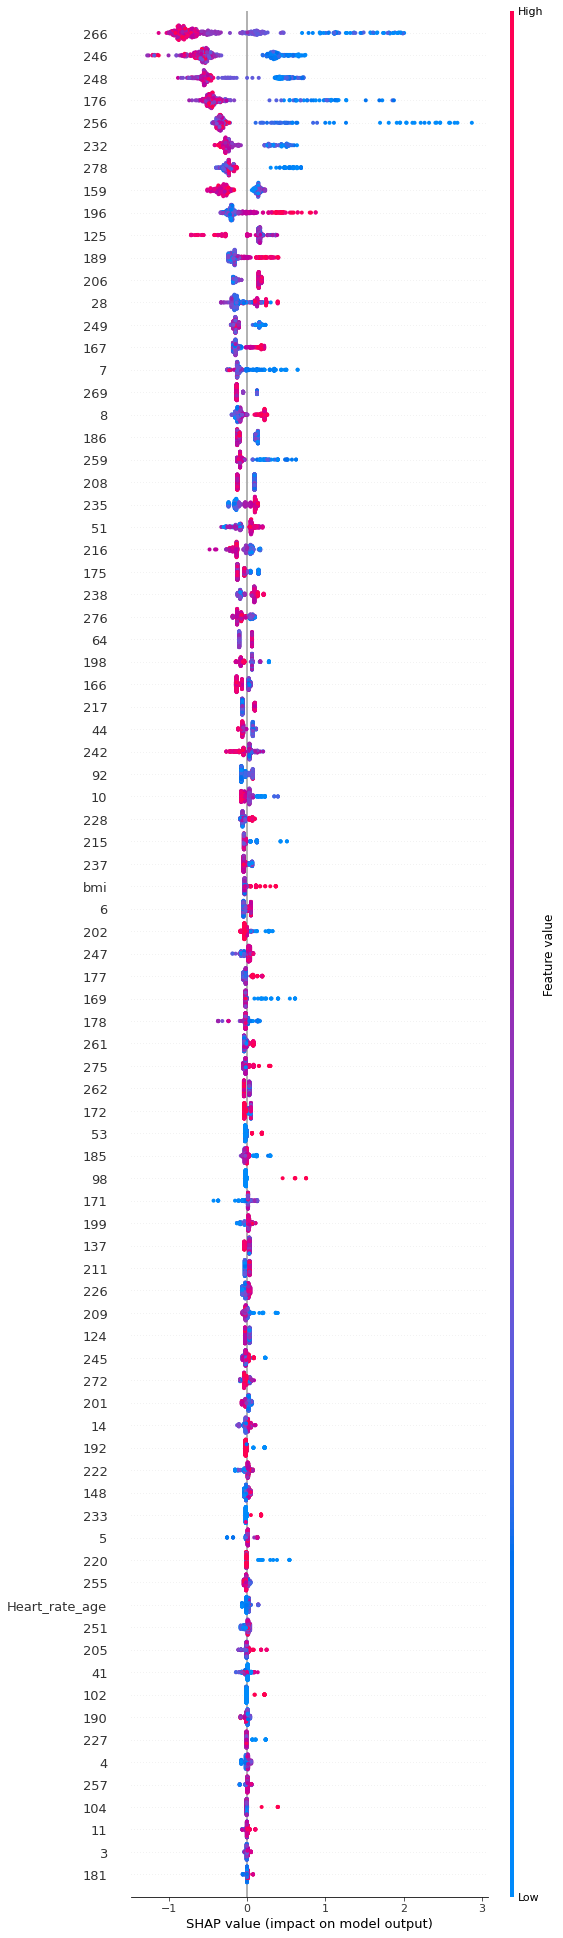

In [33]:
# summarize the effects of all the features
shap.summary_plot(shap_values, x_train, max_display=83)

Как его читать: 

- значения слева от центральной вертикальной линии — отрицательные SHAP-значения
- чем толще линия на графике, тем больше таких точек наблюдения
- чем краснее точка на графике, тем выше значения признака в ней

**Так как большинство признаков (кроме 5-ти) относятся к специальным параметрам замера сердечного ритма их понимание затруднено**.

Из графика можно сделать следующие выводы:
- индекс массы тела bmi показывает что его превышение увеличивает риск нарушений работы сердца. А его уменьшение, не снижает, а просто оставляет в районе нуля.
- 14-й признак (пульс) - увеличение пульса увеличивает риск нарушений работы сердца
- heart_rate_age - отношение пульса к возрасту показывает, что повышенное или пониженное отношение понижает риски. Т.к. с возрастом пульс снижается, было бы полезно разбить возраст на интервалы и рассчитываать отношение для каждой возрастной группы.
- признак 3 (вес) ясно показывает что повышенный вес повышает, а пониженый - снижает риск.

Можно даже просто взять средние значения SHAP для каждого признака

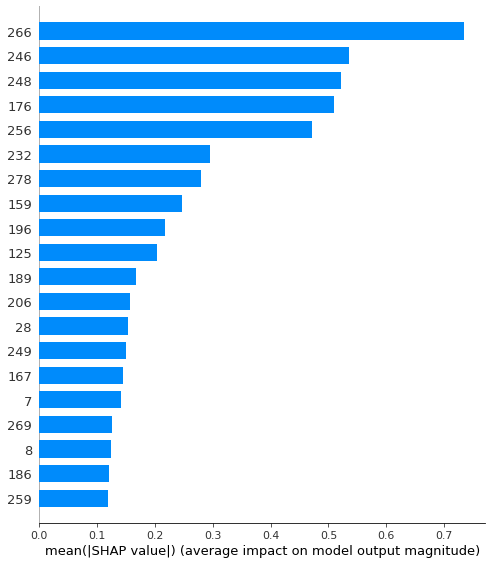

In [34]:
shap.summary_plot(shap_values, x_train, plot_type="bar")

**Вывод**: наибольший вклад вносят признаки 266, 246, 248, 176, 256. Но так как эти признаки относятся к параметрам замера сердечного ритма их понимание затруднено.

In [35]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[196,:], x_train.iloc[196,:])

In [36]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[175,:], x_train.iloc[175,:])

In [37]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[25,:], x_train.iloc[25,:])

У пациента с индексом 25 очень высокий индекс массы тела (ожирение) является серьёзным вкладом.

In [38]:
shap.force_plot(explainer.expected_value, shap_values[20,:], x_train.iloc[20,:])